In [6]:
# --- Step 1: Load Feature Data ---

import pandas as pd
import numpy as np

# Adjust the path if your features file has a different name or location
features_path = 'Data/features_df.csv'  # Change if needed
features_df = pd.read_csv(features_path)

# Check the columns and a sample
print(features_df.columns)
print(features_df.sample(5))

# --- Step 2: Prepare for LOSO Cross-Validation ---

# Ensure 'participant' and 'majority_activity' columns exist
assert 'participant' in features_df.columns, "Participant column missing!"
assert 'majority_activity' in features_df.columns, "Activity label column missing!"

participants = features_df['participant'].unique()
print(f"Participants found: {participants}")

# Ready for LOSO splitting

Index(['mean', 'std', 'skewness', 'max', 'min', 'range', 'psd_sum', 'psd_max',
       'majority_activity', 'participant'],
      dtype='object')
            mean       std  skewness        max       min      range  \
4307   11.494503  5.068050  0.553014  24.566676  2.007067  22.559609   
11656  10.274826  0.503253  6.962253  18.371525  7.234598  11.136926   
5914    9.920668  2.839952  0.249615  21.631635  2.881654  18.749980   
12405  10.645728  4.197335  0.383924  27.338861  0.789977  26.548884   
10399   9.921278  0.051232 -2.570079  10.324946  9.362604   0.962342   

          psd_sum    psd_max majority_activity  participant  
4307   140.470627  41.463318           jogging            4  
11656    0.003337   0.000054          standing           10  
5914    40.668715  10.905930            biking            5  
12405   94.868232  12.348153          upstairs           10  
10399    0.004173   0.000106          standing            9  
Participants found: [ 1  2  3  4  5  6  7  8  9 10

In [7]:
# --- Step 3: LOSO Cross-Validation Splitting Example ---

# Let's demonstrate how to split the data for one participant (e.g., participant 1)
test_participant = participants[0]  # You can loop over participants for full LOSO

# Create train and test splits
train_df = features_df[features_df['participant'] != test_participant]
test_df = features_df[features_df['participant'] == test_participant]

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Check class distribution in train and test
print("Train activity distribution:")
print(train_df['majority_activity'].value_counts())
print("\nTest activity distribution:")
print(test_df['majority_activity'].value_counts())

Train set shape: (11321, 10)
Test set shape: (1260, 10)
Train activity distribution:
majority_activity
jogging       1629
biking        1629
standing      1620
downstairs    1619
sitting       1611
upstairs      1611
walking       1602
Name: count, dtype: int64

Test activity distribution:
majority_activity
jogging       181
biking        181
downstairs    181
standing      180
walking       179
sitting       179
upstairs      179
Name: count, dtype: int64


In [8]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# --- Step 4: LOSO Cross-Validation Loop with SVM ---

svm_results = []

for pid in participants:
    # Split data
    train_df = features_df[features_df['participant'] != pid]
    test_df = features_df[features_df['participant'] == pid]
    
    # Features and labels
    X_train = train_df.drop(['majority_activity', 'participant'], axis=1)
    y_train = train_df['majority_activity']
    X_test = test_df.drop(['majority_activity', 'participant'], axis=1)
    y_test = test_df['majority_activity']
    
    # Train SVM classifier
    n_features = X_train.shape[1]
    svm_clf = SVC(kernel='rbf', C=1, gamma=1/n_features, random_state=42)
    svm_clf.fit(X_train, y_train)
    
    # Predict
    y_pred = svm_clf.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    svm_results.append({'participant': pid, 'accuracy': acc, 'report': report})

    print(f"SVM Participant {pid} - Accuracy: {acc:.3f}")

# Optionally, aggregate results
mean_svm_acc = np.mean([r['accuracy'] for r in svm_results])
print(f"\nMean LOSO SVM Accuracy: {mean_svm_acc:.3f}")

SVM Participant 1 - Accuracy: 0.717
SVM Participant 2 - Accuracy: 0.747
SVM Participant 3 - Accuracy: 0.625
SVM Participant 4 - Accuracy: 0.713
SVM Participant 5 - Accuracy: 0.747
SVM Participant 6 - Accuracy: 0.794
SVM Participant 7 - Accuracy: 0.798
SVM Participant 8 - Accuracy: 0.878
SVM Participant 9 - Accuracy: 0.787
SVM Participant 10 - Accuracy: 0.487

Mean LOSO SVM Accuracy: 0.729


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Reduced parameter grid for SVM, including 'poly' kernel but fewer values
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [2, 3]  # Only used for 'poly' kernel
}

# Use a subset of the training data for speed if needed
X_sample = X_train
y_sample = y_train

# Grid search with 3-fold cross-validation (faster)
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_sample, y_sample)

print("Best parameters found:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Train SVM with best parameters on full training set
svm_best = SVC(**grid.best_params_, random_state=42)
svm_best.fit(X_train, y_train)
y_pred_best = svm_best.predict(X_test)

acc_best = accuracy_score(y_test, y_pred_best)
print(f"Test accuracy with best SVM: {acc_best:.3f}")
print(classification_report(y_test, y_pred_best))

Best parameters found: {'C': 10, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
Best cross-validation accuracy: 0.7750440917107584
Test accuracy with best SVM: 0.766
              precision    recall  f1-score   support

      biking       0.97      0.97      0.97       181
  downstairs       0.32      0.33      0.32       171
     jogging       0.99      0.98      0.98       181
     sitting       1.00      0.96      0.98       179
    standing       0.99      0.99      0.99       180
    upstairs       0.73      0.99      0.84       179
     walking       0.12      0.08      0.10       170

    accuracy                           0.77      1241
   macro avg       0.73      0.76      0.74      1241
weighted avg       0.74      0.77      0.75      1241



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# --- Step 4: LOSO Cross-Validation Loop with Hyperparameter Optimization ---

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

results = []

for pid in participants:
    # Split data
    train_df = features_df[features_df['participant'] != pid]
    test_df = features_df[features_df['participant'] == pid]
    
    # Features and labels
    X_train = train_df.drop(['majority_activity', 'participant'], axis=1)
    y_train = train_df['majority_activity']
    X_test = test_df.drop(['majority_activity', 'participant'], axis=1)
    y_test = test_df['majority_activity']
    
    # Hyperparameter tuning with GridSearchCV (3-fold CV for speed)
    grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    
    # Train classifier with best parameters
    clf = RandomForestClassifier(**best_params, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({'participant': pid, 'accuracy': acc, 'report': report, 'best_params': best_params})

    print(f"Participant {pid} - Accuracy: {acc:.3f} - Best Params: {best_params}")

# Optionally, aggregate results
mean_acc = np.mean([r['accuracy'] for r in results])
print(f"\nMean LOSO Accuracy: {mean_acc:.3f}")

Participant 1 - Accuracy: 0.705 - Best Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Participant 2 - Accuracy: 0.859 - Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Participant 3 - Accuracy: 0.818 - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Participant 4 - Accuracy: 0.690 - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Participant 5 - Accuracy: 0.720 - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Participant 6 - Accuracy: 0.855 - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Participant 7 - Accuracy: 0.721 - Best Params: {'max_depth

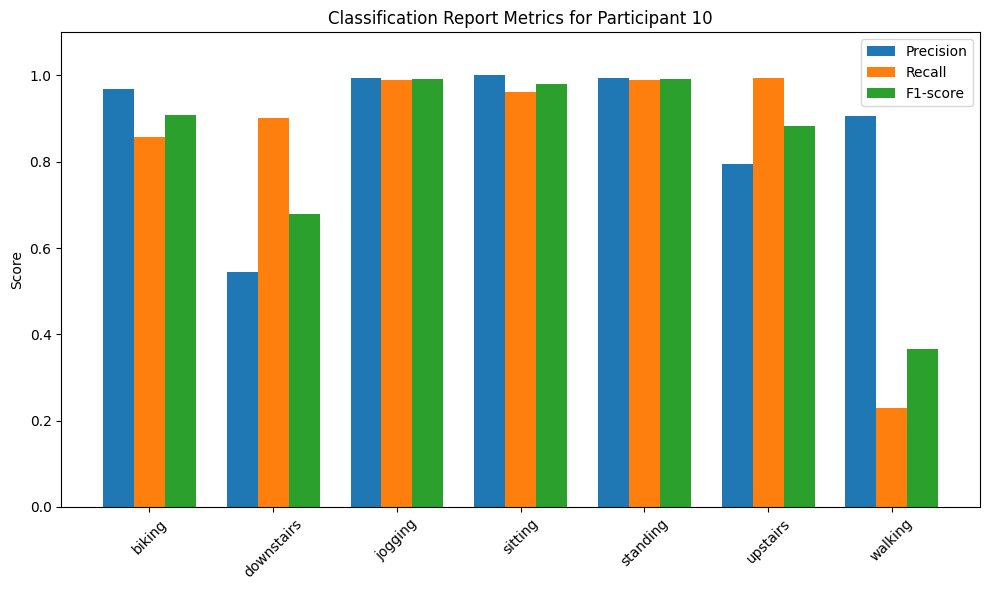

In [12]:
# --- Step 5: Visualize Classification Report for Last Participant ---

import matplotlib.pyplot as plt

# Extract per-class metrics from the last report
labels = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1 = [report[label]['f1-score'] for label in labels]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-score')

ax.set_ylabel('Score')
ax.set_title(f'Classification Report Metrics for Participant {pid}')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()

In [13]:
from sklearn.neural_network import MLPClassifier

# Define and train MLP with 1 hidden layer and momentum
mlp = MLPClassifier(hidden_layer_sizes=(100,), solver='sgd', momentum=0.9, max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

# Predict and evaluate
y_pred_mlp = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Test Accuracy: {mlp_acc:.3f}")
print(classification_report(y_test, y_pred_mlp))

MLP Test Accuracy: 0.588
              precision    recall  f1-score   support

      biking       0.97      0.87      0.92       181
  downstairs       0.29      0.27      0.28       171
     jogging       1.00      0.97      0.98       181
     sitting       0.45      0.53      0.49       179
    standing       0.42      0.34      0.38       180
    upstairs       0.63      0.93      0.75       179
     walking       0.22      0.16      0.19       170

    accuracy                           0.59      1241
   macro avg       0.57      0.58      0.57      1241
weighted avg       0.57      0.59      0.57      1241

